In [21]:
"""
Problem Set 2
Question 2
Optimal Covid - Lockdown
"""

'\nProblem Set 2\nQuestion 2\nOptimal Covid - Lockdown\n'

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import LinearConstraint, minimize, fsolve
import seaborn as sns
import os
os.chdir("path")

In [23]:
parameters = {
    "A_f" : 1, "A_nf" : 1,
    "rho" : 1.1, "omega" : 20, "gamma" : 0.9,
    "i_0" : 0.2, "N" : 1,
    "k_f" : 0.2, "k_nf" : 0.2
}

In [24]:
class CovidLockdown:

    def __init__(self, parameters):
        self.parameters = parameters

    def CoordinateGrid(self):
        """
        Define a grid of values for C(TW) and beta(HC)
        """

        beta_humanC, cost_tw = np.meshgrid(list(range(100)), list(range(100)), indexing='xy')
        beta_humanC = beta_humanC * 0.01
        cost_tw = cost_tw * 0.01


        coordinate_grid = np.array([beta_humanC, cost_tw])

        return coordinate_grid

    def MaximiseObj(self):
        """
        Define the social planners objective function
        """

        k_f = self.parameters["k_f"]
        k_nf = self.parameters["k_nf"]
        omega = self.parameters["omega"]
        gamma = self.parameters["gamma"]
        N = self.parameters["N"]
        i_0 = self.parameters["i_0"]
        A_f = self.parameters["A_f"]
        A_nf = self.parameters["A_nf"]
        rho = self.parameters["rho"]


        coordinate_grid = self.CoordinateGrid()

        results = coordinate_grid.copy()

        N = self.parameters["N"]

        for x in list(range(100)):
            for y in list(range(100)):

                C_tw, B_hc = coordinate_grid[:, x, y]

                Y = lambda H_f, H_nf: (A_f * (H_f ** ((rho - 1) / rho))
                               + C_tw * A_nf * (H_nf ** ((rho - 1) / rho))) ** (rho / (rho - 1))

                D = lambda H_f: (1 - gamma) * B_hc * ((i_0*H_f) / N) * H_f


                def objective_func(H0):
                    H_f = H0[0]
                    H_nf = H0[1]
                    return -1*(Y(H_f, H_nf)- k_f * H_f - k_nf * H_nf - omega * D(H_f))

                #initial guess
                H0 = np.array([0.5, 0.5])

                #Constraints
                A = np.array([-1, -1])
                b = np.array([-N])
                bnds = [(0, 1), (0, 1)]

                #optimise

                con1 = {"type" : "ineq", "fun" : lambda x: A @ x - b}

                solution = minimize(objective_func, H0, method="SLSQP", bounds=bnds, constraints=con1)
                results[:, x, y] = solution.x

        return results


    def Measures(self):
        """
        Solve for output, consumption and investment as a
        function of capital
        """

        coordinate_grid = self.CoordinateGrid()

        solution = self.MaximiseObj()

        workplace = solution[0]
        work_at_home = solution[1]

        TW = coordinate_grid[0]
        HC = coordinate_grid[1]

        k_f = self.parameters["k_f"]
        k_nf = self.parameters["k_nf"]
        omega = self.parameters["omega"]
        gamma = self.parameters["gamma"]
        N = self.parameters["N"]
        i_0 = self.parameters["i_0"]
        A_f = self.parameters["A_f"]
        A_nf = self.parameters["A_nf"]
        rho = self.parameters["rho"]

        A = A_f*(workplace**((rho-1)/rho))
        B = TW*A_nf*(work_at_home**((rho-1)/rho))
        Y = (A + B)**(rho / (rho-1))

        Infections = (HC*((i_0*workplace)/N)) * workplace

        Deaths = (1-gamma)*Infections

        Welfare = Y - k_f*workplace - k_nf*work_at_home - omega*Deaths

        H = np.array(solution[0] + solution[1])
        H = np.around(H, decimals=3)

        Hf_H_ratio = np.array(solution[0] / H)



        return [Y, Infections, Deaths, Welfare, H, Hf_H_ratio]

In [25]:
Question1 = CovidLockdown(parameters)

In [26]:
solution = Question1.MaximiseObj()
workplace = solution[0]
work_at_home = solution[1]

Statistics = Question1.Measures()

Y = Statistics[0]
Infections = Statistics[1]
Deaths = Statistics[2]
Welfare = Statistics[3]

H = Statistics[4]
Hf_H_ratio = Statistics[5]

In [27]:

def Plots(workplace, work_at_home, Y, Welfare, Infections, Deaths, H, Hf_H_ratio, title="Set"):

    fig, axs = plt.subplots(4,2,figsize=(14,7), facecolor="w")
    fig.tight_layout(pad=4.5)
    fig.suptitle(title, fontsize=16)

    plt.text(0.02, 0.3, "Conditional Infection Rate (Human Contact)", fontsize=14, rotation=90, transform=plt.gcf().transFigure)
    plt.text(0.3, 0.02, "Productivity Cost of Telework", fontsize=14, transform=plt.gcf().transFigure)

    sns.heatmap(H,cmap="Spectral",cbar_kws={"label": "Hours"},ax=axs[0][0])
    axs[0][0].set_title("Total Employment")

    sns.heatmap(Hf_H_ratio,cmap="Spectral",cbar_kws={"label": "Hours"},ax=axs[0][1])
    axs[0][1].set_title("Hours at Workplace to Total Ratio")

    sns.heatmap(workplace, cmap="Spectral",cbar_kws={"label": "Hours"},ax=axs[1][0])
    axs[1][0].set_title("Hours at the Workplace")

    sns.heatmap(work_at_home,cmap="Spectral",cbar_kws={"label": "Hours"},ax=axs[1][1])
    axs[1][1].set_title("Hours Teleworked")

    sns.heatmap(Y,cmap="Spectral",cbar_kws={"label": "Output"},ax=axs[2][0])
    axs[2][0].set_title('Output')

    sns.heatmap(Welfare,cmap="Spectral",cbar_kws={"label": "Welfare"},ax=axs[2][1])
    axs[2][1].set_title('Welfare')

    sns.heatmap(Infections,cmap="Spectral",cbar_kws={"label": "Infections"},ax=axs[3][0])
    axs[3][0].set_title('Infections')

    sns.heatmap(Deaths,cmap="Spectral",cbar_kws={"label": 'Deaths'},ax=axs[3][1])
    axs[3][1].set_title('Deaths')

    fig.savefig(title)

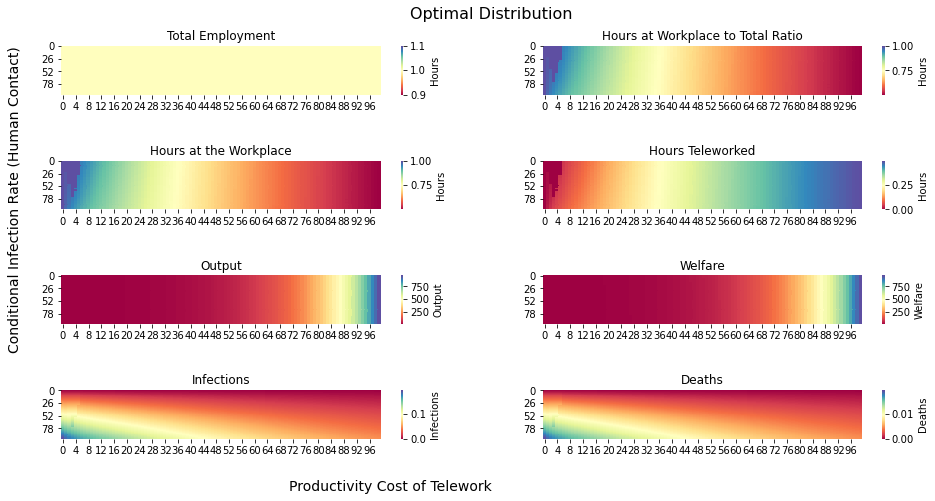

In [28]:
Plots(workplace, work_at_home, Y, Welfare, Infections, Deaths, H, Hf_H_ratio, title="Optimal Distribution")

In [29]:
Question2 = CovidLockdown(parameters)

In [30]:
Question2.parameters["rho"] = 10

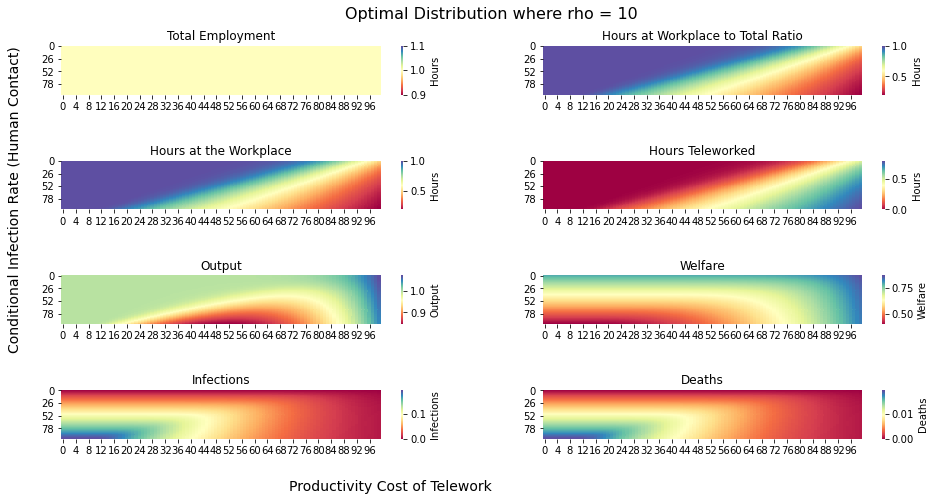

In [31]:
solution2 = Question2.MaximiseObj()
workplace2 = solution2[0]
work_at_home2 = solution2[1]
Statistics2 = Question2.Measures()
Y2 = Statistics2[0]
Infections2 = Statistics2[1]
Deaths2 = Statistics2[2]
Welfare2 = Statistics2[3]
H2 = Statistics2[4]
Hf_H_ratio2 = Statistics2[5]

Plots(workplace2, work_at_home2, Y2, Welfare2, Infections2, Deaths2, H2, Hf_H_ratio2, title="Optimal Distribution where rho = 10")

In [32]:
Question2b = CovidLockdown(parameters)

In [33]:
Question2b.parameters["omega"] = 100
Question2.parameters["rho"] = 1.1

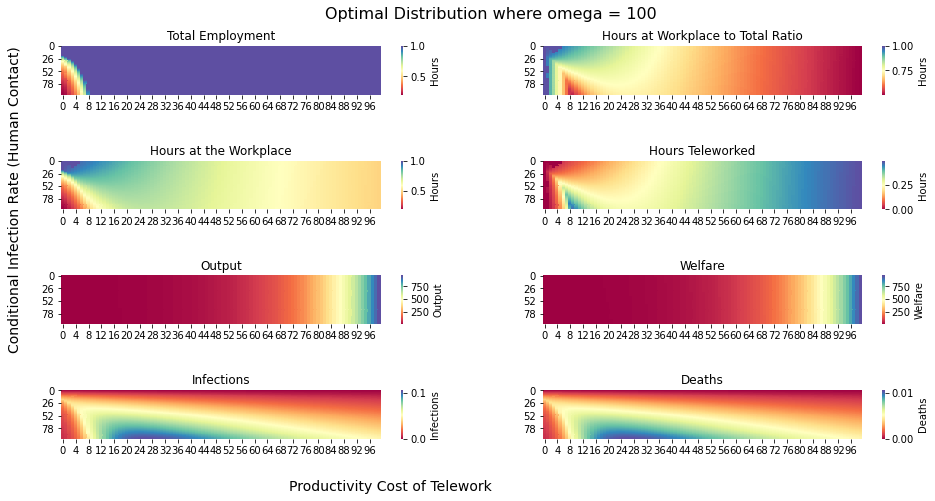

In [34]:
solution2b = Question2b.MaximiseObj()
workplace2b = solution2b[0]
work_at_home2b = solution2b[1]
Statistics2b = Question2b.Measures()
Y2b = Statistics2b[0]
Infections2b = Statistics2b[1]
Deaths2b = Statistics2b[2]
Welfare2b = Statistics2b[3]
H2b = Statistics2b[4]
Hf_H_ratio2b = Statistics2b[5]

Plots(workplace2b, work_at_home2b, Y2b, Welfare2b, Infections2b, Deaths2b, H2b, Hf_H_ratio2b, title=r"Optimal Distribution where omega = 100")

In [35]:
Question2c = CovidLockdown(parameters)

In [36]:
Question2c.parameters["omega"] = 0
Question2.parameters["rho"] = 10

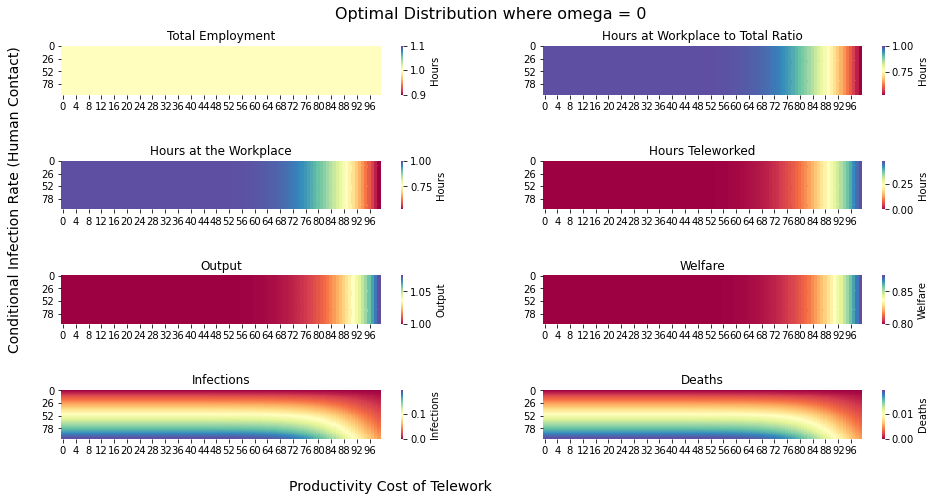

In [37]:
solution2c = Question2c.MaximiseObj()
workplace2c = solution2c[0]
work_at_home2c = solution2c[1]
Statistics2c = Question2c.Measures()
Y2c = Statistics2c[0]
Infections2c = Statistics2c[1]
Deaths2c = Statistics2c[2]
Welfare2c = Statistics2c[3]
H2c = Statistics2c[4]
Hf_H_ratio2c = Statistics2c[5]

Plots(workplace2c, work_at_home2c, Y2c, Welfare2c, Infections2c, Deaths2c, H2c, Hf_H_ratio2c, title= "Optimal Distribution where omega = 0")

